In [1]:
import os

os.chdir('../')
os.getcwd()

'/home/bitwalk/MyProjects/stock-explorer'

In [25]:
# ライブラリーの読み込み
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt

import datetime as dt
import mplfinance as mpf
import yfinance as yf

# グラフのスタイルとサイズ
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

[*********************100%%**********************]  1 of 1 completed


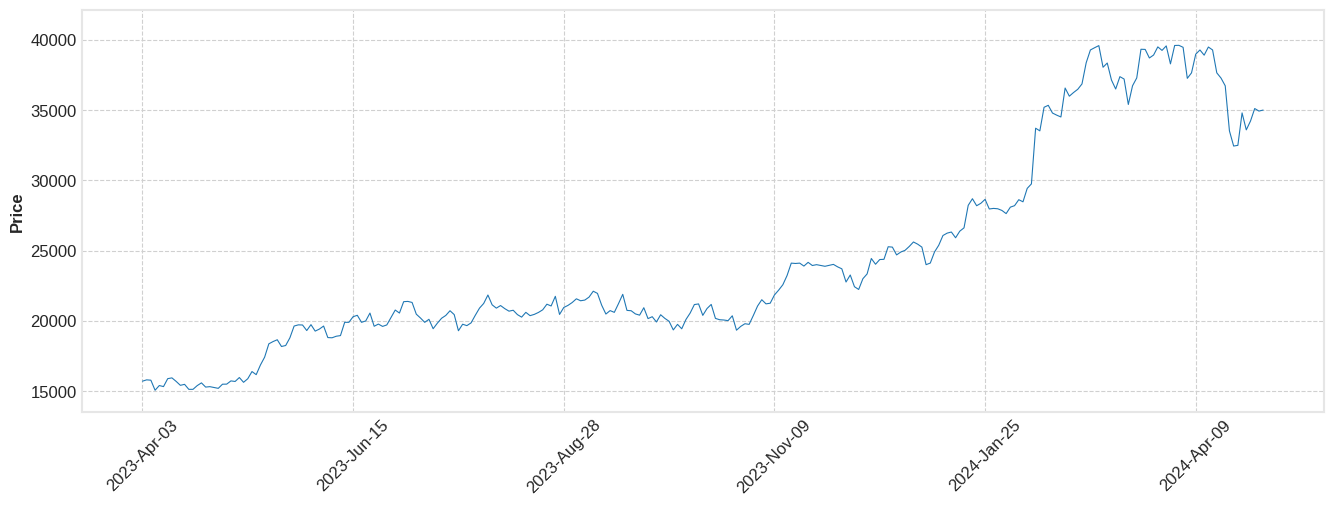

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-03,16040.0,16050.0,15600.0,15710.0,15509.020508,3399600
2023-04-04,15880.0,15935.0,15675.0,15805.0,15602.804688,3029900
2023-04-05,15610.0,15970.0,15585.0,15780.0,15578.124023,3264600
2023-04-06,15380.0,15380.0,14930.0,15065.0,14872.272461,4860200
2023-04-07,15250.0,15480.0,15155.0,15400.0,15202.985352,3042700
...,...,...,...,...,...,...
2024-04-25,33530.0,34360.0,33400.0,33600.0,33600.000000,3712900
2024-04-26,34250.0,34780.0,33730.0,34230.0,34230.000000,4399400
2024-04-30,35000.0,35520.0,34810.0,35120.0,35120.000000,3262700


In [104]:
start = dt.date(2023, 4, 1)
end = dt.date(2024, 5, 5)

#ticker = '7735.T' # スクリーン
ticker = '8035.T' # 東京エレクトロン
df = yf.download(ticker, start, end)
mpf.plot(df, type='line', style='binance', figratio=(12, 4))
df

In [132]:
date0 = '2024-04-14'

In [133]:
df_train = pd.DataFrame(df[:date0]['Close'])
df_train

,Close
Date,
2023-04-03,15710.0
2023-04-04,15805.0
2023-04-05,15780.0
2023-04-06,15065.0
2023-04-07,15400.0
...,...
2024-04-08,37660.0
2024-04-09,38990.0
2024-04-10,39290.0


In [134]:
df_test = pd.DataFrame(df[date0:]['Close'])
df_test

,Close
Date,
2024-04-15,39290.0
2024-04-16,37660.0
2024-04-17,37290.0
2024-04-18,36740.0
2024-04-19,33530.0
2024-04-22,32450.0
2024-04-23,32500.0
2024-04-24,34810.0
2024-04-25,33600.0


# 手動構築（SARIMAX関数）

In [184]:
# 原系列を学習データとする
train = df_train
# 学習
sarima_model = SARIMAX(
    train, order=(1, 1, 1),
    seasonal_order=(0, 1, 0, 7),
    trend=[1, 1, 1, 1]
)

sarima_fit = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.94084D+00    |proj g|=  6.38923D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0   6.389D+01   7.941D+00
  F =   7.9408373238077257     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

In [185]:
# 予測
##学習データの期間の予測値
train_pred = sarima_fit.predict()
##テストデータの期間の予測値
test_pred = sarima_fit.forecast(len(df_test))
##予測区間
test_pred_ci = sarima_fit.get_forecast(len(df_test)).conf_int() 
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test, test_pred))

RMSE:
2998.3987667123693
MAE:
2372.3590638999785
MAPE:
0.07006812696474377


/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


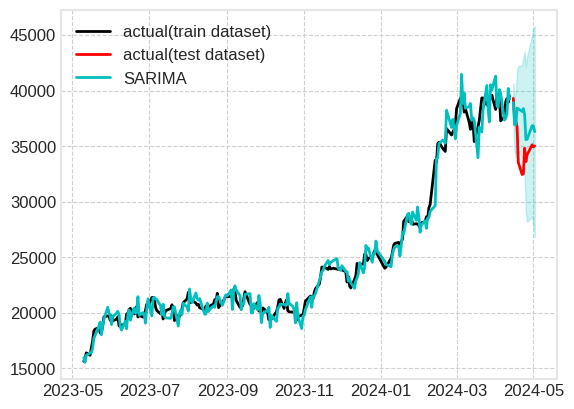

In [186]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)", color="black")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="red")
ax.plot(df_train[24:].index, train_pred[24:].values, color="c")
ax.plot(df_test.index, test_pred.values, label="SARIMA", color="c") 
ax.fill_between(
    df_test.index,
    test_pred_ci.iloc[:, 0],
    test_pred_ci.iloc[:, 1],
    color='c',
    alpha=.2)
ax.legend()

# 自動構築（auto_arima関数）

In [181]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(
    train,
    seasonal=True,
    m = 7,
    trace=True,
    n_jobs=1,
    maxiter=10
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=3982.892, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3973.858, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3975.862, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3976.007, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3977.649, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=3974.411, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=3974.464, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=3976.403, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=3975.257, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3975.361, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=3974.733, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7] intercept
Total fit time: 0.337 seconds


In [182]:
# 予測
##学習データの期間の予測値
train_pred = arima_model.predict_in_sample()
##テストデータの期間の予測値
test_pred, test_pred_ci = arima_model.predict(
    n_periods=df_test.shape[0], 
    return_conf_int=True
)
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test, test_pred))

RMSE:
5451.563934009865
MAE:
4991.298266950443
MAPE:
0.14575557153828342


/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


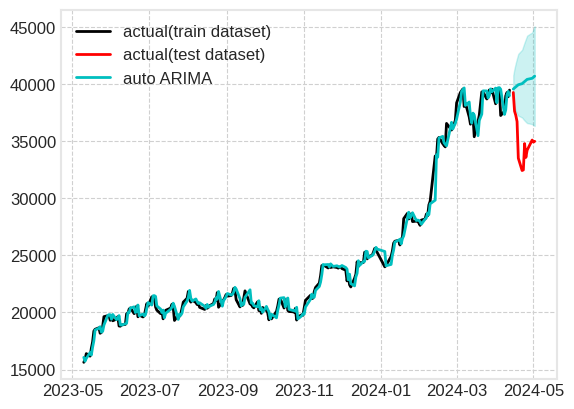

In [183]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)", color="black")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="red")
ax.plot(df_train[24:].index, train_pred[24:], color="c")
ax.plot(df_test.index, test_pred, label="auto ARIMA", color="c") 
ax.fill_between(
    df_test.index,
    test_pred_ci[:, 0],
    test_pred_ci[:, 1],
    color='c',
    alpha=.2)
ax.legend()

# ハイブリッド構築（階差の次数のみ指定）

階差の次数のみ指定し、auto_arima関数を使い、ARIMAモデルを構築します。

In [142]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(
    train, 
    seasonal=True,
    m=7,
    d=1,
    D=1,
    trace=True,
    n_jobs=1,
    maxiter=10
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=3966.007, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=4048.185, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=3992.150, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=3959.929, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=4049.375, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=3961.326, Time=0.08 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=3961.309, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=3992.832, Time=0.06 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=3963.492, Time=0.18 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=3908.875, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=3920.729, Time=0.05 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=3923.061, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=3977.369, Time=0.03 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=3920.062, Time=0.15 sec
 ARIMA(1,1,0)(0,1,1)[7]          

In [143]:
# 予測
##学習データの期間の予測値
train_pred = arima_model.predict_in_sample()
##テストデータの期間の予測値
test_pred, test_pred_ci = arima_model.predict(
    n_periods=df_test.shape[0], 
    return_conf_int=True
)
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test, test_pred))

RMSE:
5674.502785791669
MAE:
5200.124594846658
MAPE:
0.15179919803714936


/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


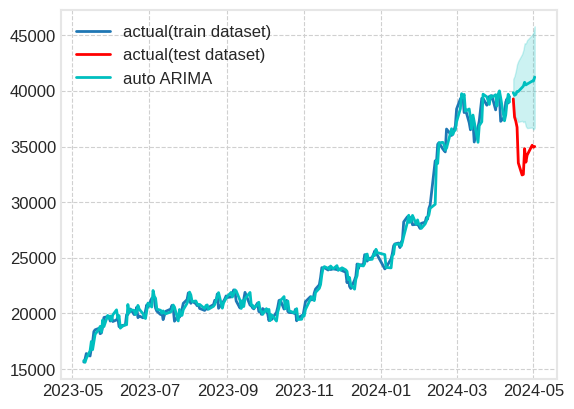

In [144]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="red")
ax.plot(df_train[24:].index, train_pred[24:], color="c")
ax.plot(df_test.index, test_pred, label="auto ARIMA", color="c") 
ax.fill_between(
    df_test.index,
    test_pred_ci[:, 0],
    test_pred_ci[:, 1],
    color='c',
    alpha=.2)
ax.legend()